In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Add Package scikit-image and scikit-learn to environment
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans

In [2]:
# FUNCTIONS
def splitImg2blocks(image, block_size):
    blocks = []
    height, width = image.shape
    block_height = height // block_size
    block_width = width // block_size
    # Calculate blocks
    for i in range(blocks_height):
        for j in range(blocks_width):
            block = image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
            blocks.append(block)
            
    return blocks

def calculateGlcms(blocks, distance, angles, levels):
    glcms = []
    glcm_size = None
    # Calculate glcm for every block and append to glcms
    for block in blocks:
        glcm = graycomatrix(block, distances=distance, angles=angles, levels=levels, symmetric=True, normed=True)
        glcms.append(glcm)
        if glcm_size is None:
            glcm_size = glcm.shape
            
    return glcms

def calculateFeatures(glcms):
    features = []
    # Calculate GLCM properties
    for glcm in glcms:
        correlation = graycoprops(glcm, 'correlation')
        contrast = graycoprops(glcm, 'contrast')
        energy = graycoprops(glcm, 'energy')
        homogeneity = graycoprops(glcm, 'homogeneity')
        features.append((correlation, contrast, energy, homogeneity))
        
    return features

def extractImagesFromFeatures(features, tile_size):
    # Extract features depending on angle
    features_a1 = [(arr[0][:, :1], arr[1][:, :1], arr[2][:, :1], arr[3][:, :1]) for arr in features]
    features_a2 = [(arr[0][:, 1:2], arr[1][:, 1:2], arr[2][:, 1:2], arr[3][:, 1:2]) for arr in features]
    features_a3 = [(arr[0][:, 2:3], arr[1][:, 2:3], arr[2][:, 2:3], arr[3][:, 2:3]) for arr in features]
    features_a4 = [(arr[0][:, 3:4], arr[1][:, 3:4], arr[2][:, 3:4], arr[3][:, 3:4]) for arr in features]

    # Extract the calculated values
    correlation_values_a1, contrast_values_a1, energy_values_a1, homogeneity_values_a1 = zip(*features_a1)
    correlation_values_a2, contrast_values_a2, energy_values_a2, homogeneity_values_a2 = zip(*features_a2)
    correlation_values_a3, contrast_values_a3, energy_values_a3, homogeneity_values_a3 = zip(*features_a3)
    correlation_values_a4, contrast_values_a4, energy_values_a4, homogeneity_values_a4 = zip(*features_a4)

    # Convert to numpy arrays
    correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4 = map(np.array, [correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4])
    contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4 = map(np.array, [contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4])
    energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4 = map(np.array, [energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4])
    homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4 = map(np.array, [homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4])

    # Cluster the values
    correlation_values = [correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4]
    contrast_values = [contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4]
    energy_values = [energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4]
    homogeneity_values = [homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4]

    # Reshape the images
    correlation_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in correlation_values]
    contrast_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in contrast_values]
    energy_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in energy_values]
    homogeneity_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in homogeneity_values]
    all_images = [correlation_images, contrast_images, energy_images, homogeneity_images]
    
    return all_images

# Medical Image Computing - Exercise 2

Jasmin Eder, Dorothea Mauracher, Sonja Pappenberger

## Image texture descriptors
#### 1.1 Load the image “breastXray.tif”. Split the image into non-overlapping blocks of 20 x 20 pixels. What is the original image size and hence how many blocks/regions are processed in the following steps?

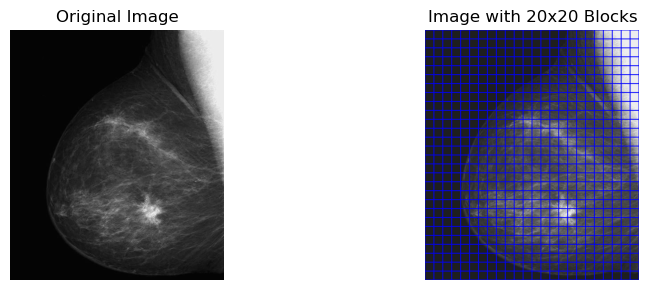

Image Type:  uint8
Image width: 480 pixels
Image height: 560 pixels
Total number of blocks in the image: 672


In [3]:
# Read the image
image = cv2.imread("breastXray.tif", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# Get image data
height, width = image.shape

# Define block size
block_size = 20

# Calculate the number of blocks in both dimensions
blocks_height = height // block_size
blocks_width = width // block_size

# Calculate the total number of blocks
total_blocks = blocks_height * blocks_width

# Split the image into blocks
blocks = splitImg2blocks(image, block_size)
             
# Create a copy of the image to draw rectangles on
image_with_blocks = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw rectangles around each block on the image
for i in range(blocks_height):
    for j in range(blocks_width):
        cv2.rectangle(image_with_blocks, (j * block_size, i * block_size),
                      ((j + 1) * block_size - 1, (i + 1) * block_size - 1), (0, 0, 255), 1)

# Plot the original image
fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs[0].imshow(image, cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('Original Image')
# Plot the split image
axs[1].imshow(image_with_blocks, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Image with 20x20 Blocks')
plt.tight_layout()
plt.show()

print("Image Type: ", image.dtype)
print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")
print(f'Total number of blocks in the image: {total_blocks}')

The original image size is 560 x 480 pixels and the split image has a total of 672 blocks.
    

#### 1.2 Determine the gray level co-occurrence matrix (GLCM) for each region/block using a position operator [Dx, Dy]. Choose a distance, e.g. D = 1, and extract the GLCM at four different directions [0°, 45°, 90°, 135°]. The number of gray levels should be set to 16. What is the size of one GLCM?

In [4]:
# Definitions for GLCM calculation
distance = [1] 
angles = [0, np.pi/4, np.pi/2, 3*np.pi/8]  # Angles in degrees: 0°, 45°, 90°, 135°

# Number of gray levels
gray_levels = 16

# Scale image with 256 gray levels to 16 gray levels
image_16 = image / 255 * 15
image_16 = image_16.astype(np.uint8)

# Create new blocks with 16 gray levels
blocks_16 = splitImg2blocks(image_16, block_size)

# Calculate GLCM for each block at different angles
glcms = calculateGlcms(blocks_16, distance, angles, gray_levels)

print("Size of one GLCM: ", glcms[0].shape)

Size of one GLCM:  (16, 16, 1, 4)


For using a gray level of 16, the image firstly needs to be rescaled from 256 gray levels to 16 gray levels. For later use the datatype needs to be an integer and therefore the image is transformed from a float to an integer type. New blocks with 16 gray levels are created. The size of one GLCM is 16 x 16.

#### 1.3 Calculate the correlation, contrast, energy and homogeneity for each GLCM. Show processed images based on the descriptors, i.e. Correlation at four directions with D = 1, Contrast at four directions with D =1, etc., using subplots (see Figure 1). How many features did you extract? Comment on the differences between the different texture descriptors

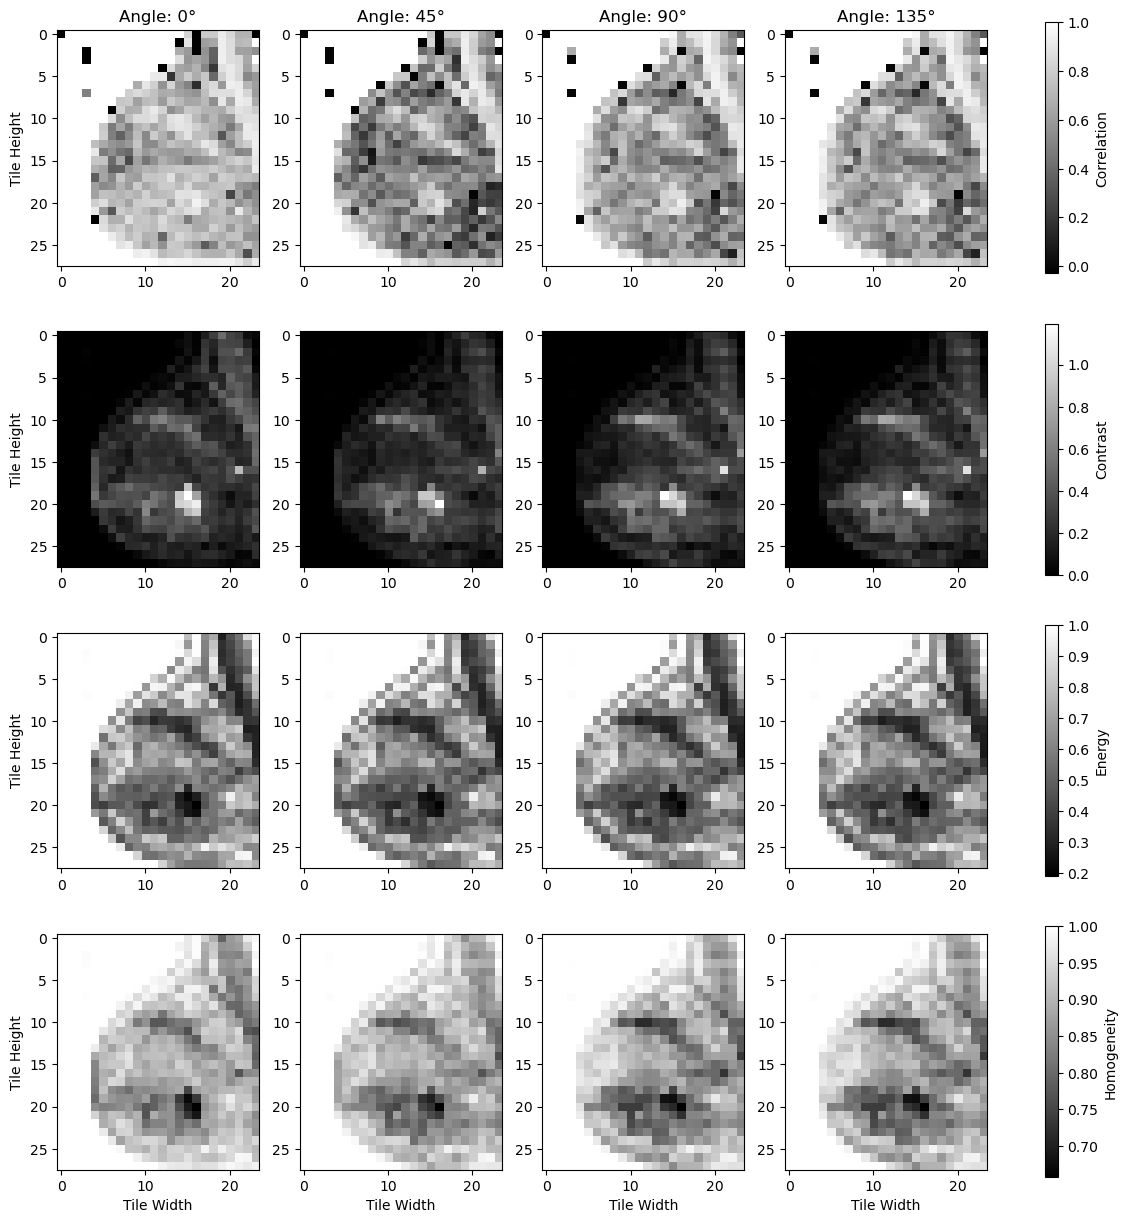

In [5]:
distance = 1
tile_size = 20 # int(np.sqrt((image.shape[0] * image.shape[1]) / correlation_values_a1.size))

# Calculate features of GLCM
features = calculateFeatures(glcms)

# Extract images
all_images = extractImagesFromFeatures(features, tile_size)

# Plot the images
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# Feature titles for colorbars
feature_titles = ['Correlation', 'Contrast', 'Energy', 'Homogeneity']

# Iterate over each row (feature type)
for i, feature_type in enumerate(all_images):
    # Iterate over each column (angle)
    for j, feature_image in enumerate(feature_type):
        axs[i, j].imshow(feature_image, cmap='gray', interpolation='nearest')
        if i == 0:
            axs[i, j].set_title(f'Angle: {j * 45}°')

    # Add colorbar at the end of each row
    pos = axs[i, -1].imshow(feature_image, cmap='gray', interpolation='nearest')
    fig.colorbar(pos, ax=axs[i, :], label=feature_titles[i])
    axs[i, 0].set_ylabel('Tile Height')

# Set x-labels for the last row
axs[-1, 0].set_xlabel('Tile Width')
axs[-1, 1].set_xlabel('Tile Width')
axs[-1, 2].set_xlabel('Tile Width')
axs[-1, 3].set_xlabel('Tile Width')

plt.show()

4 features are extracted from 4 different directions resulting in 16 different images. Correlation shows the most differences between the 4 angles. Contrast and Energy seem to be similar but inverted. Homogeneity shows some slight differences between different directions. <br>
<b>Correlation:</b> Calculation of dependencies between neighbour pixels. Brighter regions define higher correlation. <br>
<b>Contrast:</b> Calculation of variations in pixel intensities. Brighter reagions indicate higher variations. <br>
<b>Energy:</b> Calculation of ordered and uniform textures. Brighter reagions represent higher uniformity. <br>
<b>Homogeneity:</b> Calculation of the closeness of element distributio to the diagonal. Bright regions show pixels wwith similar intensities.

#### 1.4 Build a design/data matrix based on your blocks where each block/region is an observation (sample) and the texture descriptors are the features. Normalize the features in the design matrix between 0 and 1. What is the size of your design matrix?

In [6]:
# Build the design matrix using the features list
# Stack the features into the design_matrix and adapt the axes
design_matrix = np.squeeze(np.stack(features, axis=0), axis=2)
# Reshape the design matrix
design_matrix = np.reshape(design_matrix, (image.shape[0] // tile_size * image.shape[1] // tile_size, 16))

# Normalize the design matrix
minimum = np.min(design_matrix, axis=0)
maximum = np.max(design_matrix, axis=0)
design_matrix_norm = (design_matrix - minimum) / (maximum - minimum)

print(design_matrix_norm.shape)

(672, 16)


The design matrix is build using the features list from the section above. After reshaping and normalization the size of the design matrix is (672, 16). 672 blocks are used and 4 features are looked at from 4 different directions leading to a total of 16 different features at different angles.

#### 1.5. (BONUS, 1 extra point) Try two different pixel distances D, e.g. 1 and 3, and show the processed images using subplots. Comment on the influence of the distance parameter. Decide for one of the two distances D to be used in the design matrix for the second part of the exercise.

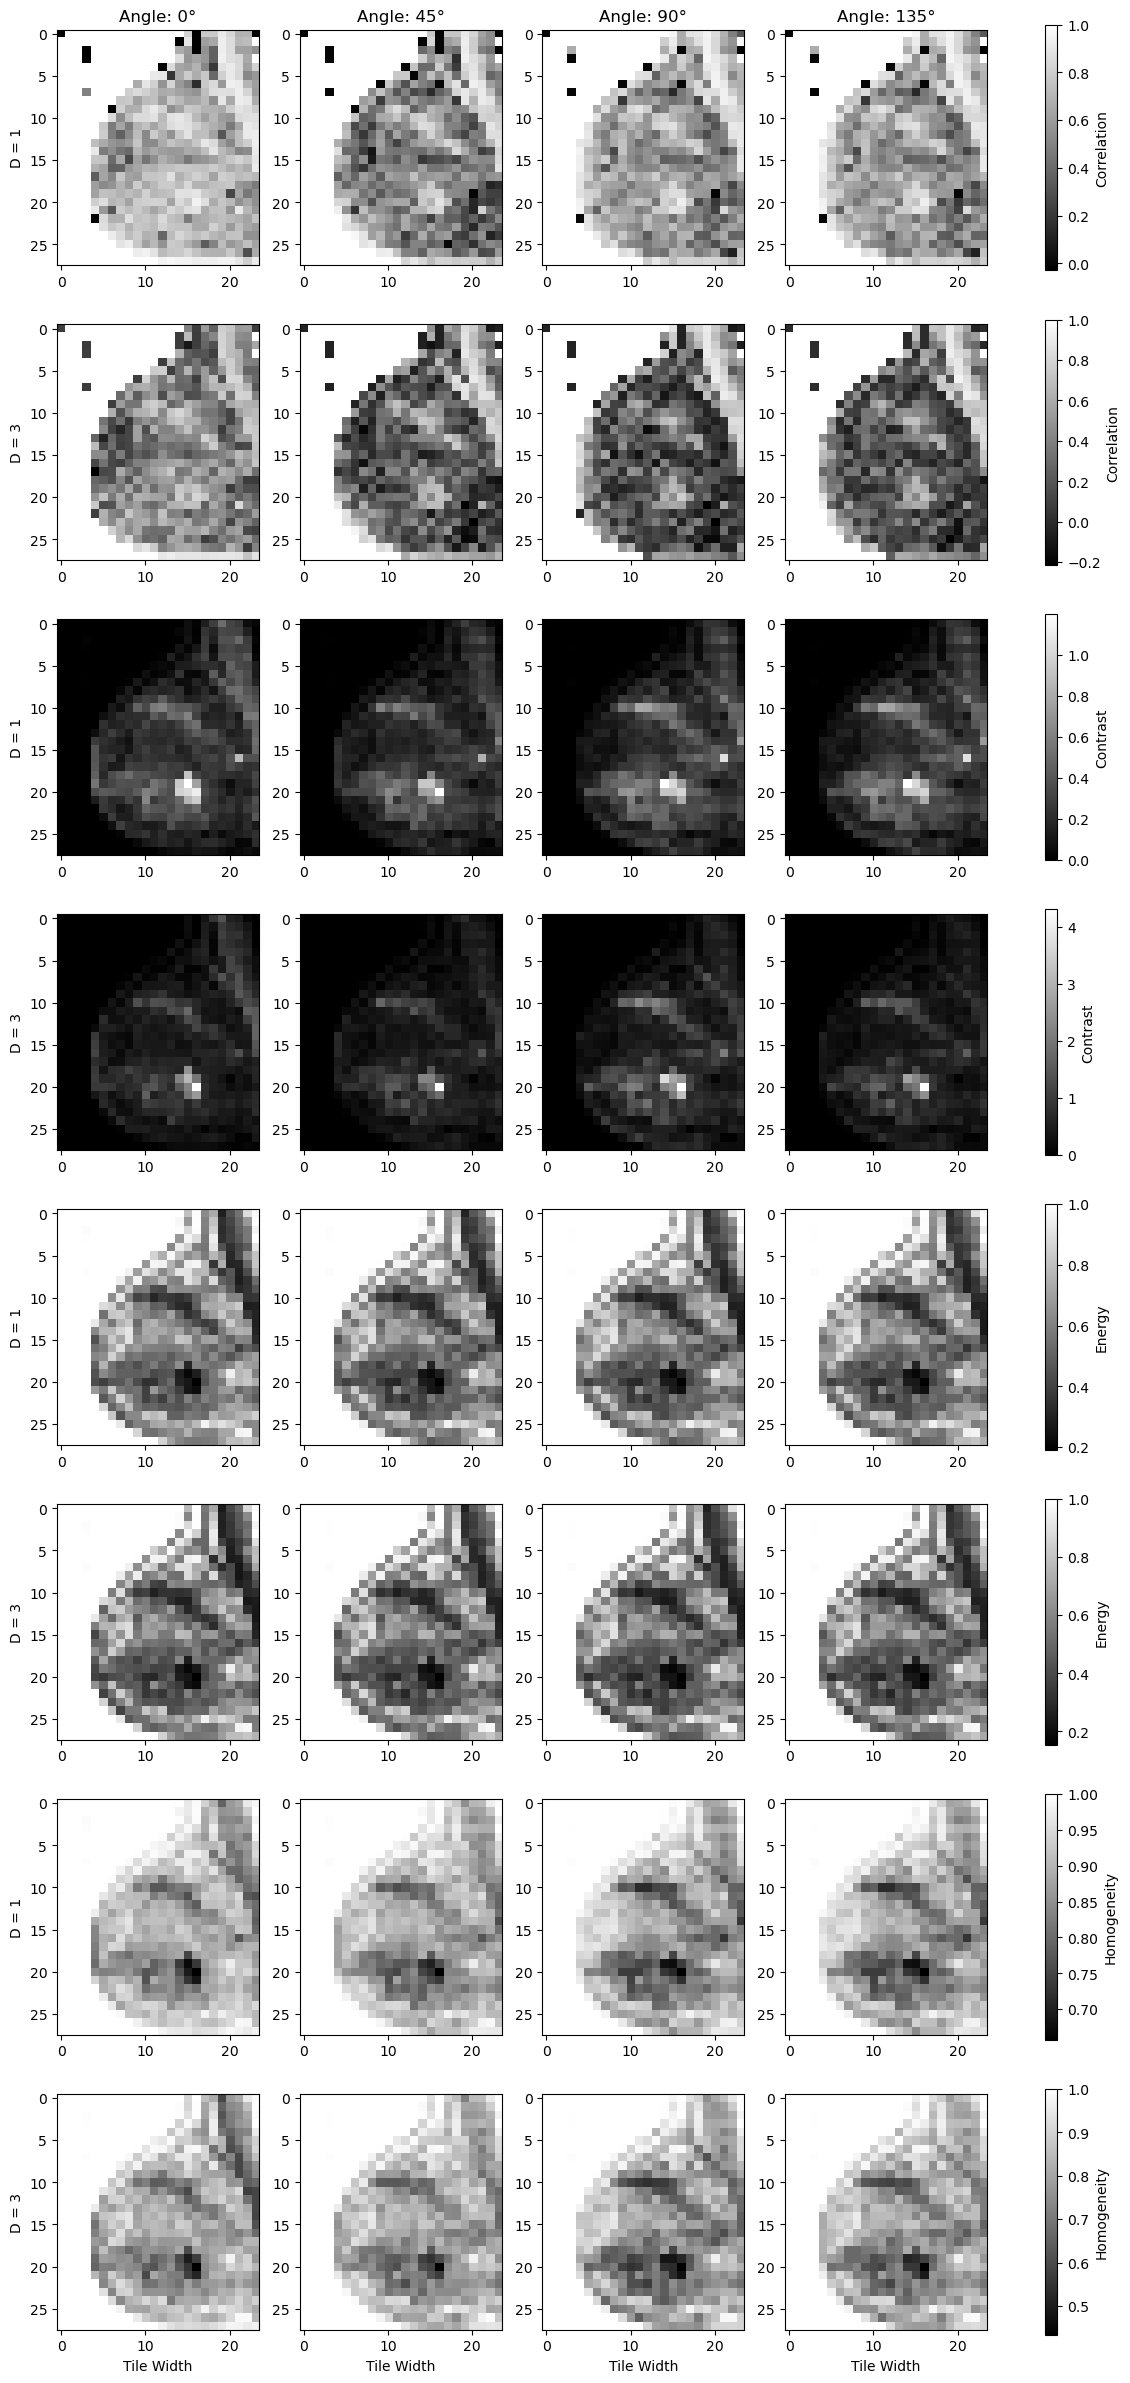

In [7]:
distance_3 = [3]
# Calculate glcms
glcms_3 = calculateGlcms(blocks_16, distance_3, angles, gray_levels)

# Calculate features of GLCM
features_3 = calculateFeatures(glcms_3)

# Extract images
all_images_3 = extractImagesFromFeatures(features_3, tile_size)

# Create a new listfor the feature title
feature_titles_combined = [title for title in feature_titles for _ in range(2)]
# Combine images with d=1 and d=3 by alternating features
all_images_combined = [image for pair in zip(all_images, all_images_3) for image in pair]

# Plot the images
fig, axs = plt.subplots(8, 4, figsize=(15, 30))

# Iterate over each row (feature type)
for i, feature_images_combined in enumerate(all_images_combined):
        # Iterate over each column (angle)
    for j, feature_image_combined in enumerate(feature_images_combined):
        axs[i, j].imshow(feature_image_combined, cmap='gray', interpolation='nearest')
        # Set title for the first row (angles)
        if i == 0:
            axs[i, j].set_title(f'Angle: {j * 45}°')
        # Add colorbar at the end of each set of images
        if j == 3:
            pos = axs[i, -1].imshow(feature_image_combined, cmap='gray', interpolation='nearest')
            # Set the appropriate title and label for the colorbar
            fig.colorbar(pos, ax=axs[i, :], label=feature_titles_combined[i])
            # Set ylabel for every row
            if i % 2 == 0:
                axs[i, 0].set_ylabel('D = 1')
            else:
                axs[i, 0].set_ylabel('D = 3')

# Set x-labels for the last row
for j in range(4):
    axs[-1, j].set_xlabel('Tile Width')

plt.show()

Differences in the distance can best be seen in the correlation and contrast feature. In energy and homogeneity the values seem to be rather similar. With a bigger distance of 3, the values on the grayscale are darker. In the contrast feature this leads to a loss of information. Therefore the design matrix with the distance of 1 is used for further analysis.

## Texture-based clustering
#### 2.1. Cluster the blocks represented by the design matrix using k-means clustering. Use k=4 and use at least 10 repeats for the initialization

In [8]:
import os
import warnings
# Set the environment variable to avoid the memory leak warning
os.environ['OMP_NUM_THREADS'] = '3'
# Suppress the warning from scikit-learn KMeans
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

k = 4
repeats = 12

# Apply k means on the normalized design matrix with distance = 1
k_means = KMeans(n_clusters=k, n_init=repeats, random_state=0)
clusters = k_means.fit_predict(design_matrix_norm)

# Reshape the cluster
image_cluster = clusters.reshape(image.shape[0] // tile_size, image.shape[1] // tile_size)

#### 2.2. Visualize the blocks corresponding to the four different labels as an overlay to the original image, i.e. mask the original image with the labels found by the k-means algorithm. Which regions in the image were found? Describe the characteristics of the regions.

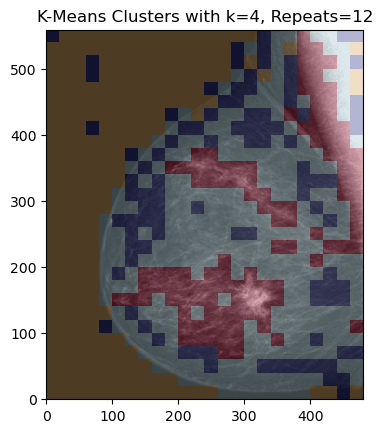

In [9]:
# Plot the original image and the clustered blocks
fig, axs = plt.subplots()
# Show original image
axs.imshow(image, cmap='gray', extent=[0,image.shape[1], 0, image.shape[0]])
# Overlay of k means clusters
axs.imshow(image_cluster, cmap='RdYlBu', extent=[0,image.shape[1], 0, image.shape[0]], alpha=0.3) 
axs.set_title(f"K-Means Clusters with k={k}, Repeats={repeats}")

axs.set_xlim(0, max(image.shape[1], image_cluster.shape[1]))
axs.set_ylim(0, max(image.shape[0], image_cluster.shape[0]))

plt.show()

The breast can be extractd from the background, which is shown in yellow. The breast tissue is again clustered into different regions. Brighter regions are shown in red, indicating more vessels which could identify breast cancer for further diagnosis. Other breast tissue which is displayed darker in the x-ray is shown in blue and turquoise. 